In [1]:
from utils.data_handling import *
from utils.sensor_optimisation import *
from parameters import *
import GPy
import scipy.stats
from sklearn.covariance import GraphicalLasso


import matplotlib.pyplot as plt
np.random.seed(101)
%matplotlib inline

### Importing the Tracer Data to Select the Optimisation set S

In [2]:
parameters['i_end'] = 988
parameters['field_name'] = "Tracer"
parameters

{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Tracer',
 'cov_method': 'sample'}

In [3]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


### Working subset of the data : set S

In [4]:
S_human = human_level_subset(buildingshape, loc_df, 2,1 )
print("The remaining number of points is : ", str(len(S_human)))

The remaining number of points is :  37847


In [5]:
S_working = working_subset(data_df, loc_df, nbins = (25,25,25), threshold_sum = 10**-2 )
print("The remaining number of points is : ", str(len(S_working)))

The remaining number of points is :  57725


In [6]:
S = np.intersect1d(S_human,S_working)
print("The remaining number of points is : ", str(len(S)))

The remaining number of points is :  23643


### Import the Field of interest for computing the optimisation : TracerBackground / Pressure

In [7]:
parameters['i_end'] = 988
parameters['field_name'] = "Tracer"
parameters


{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Tracer',
 'cov_method': 'sample'}

In [8]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


In [9]:
X = loc_df.values #[I,:dim]
Z = data_df.values#[:,t].reshape(-1,1) # [I,t].reshape(-1,1)
Z.shape

(100040, 989)

### Detrending Data : 
Plotting the data along each direction in order to see if there is a obvious trend. It seams that it is not the case. 

In [12]:
# Tracer Starting point
X_0 = X[np.unravel_index(Z.argmax(), Z.shape)[0],:]
X_0

array([-23.50261288,  25.09719562,  11.76448376])

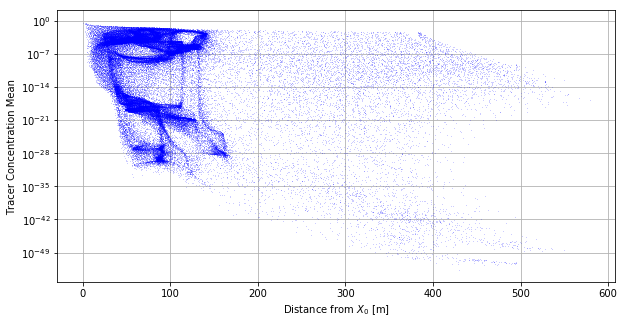

In [13]:
fig =plt.figure(figsize=(10,5))
ax = plt.gca()
ax.set_yscale('log')
#ax.set_xscale('log')
ax.plot(np.linalg.norm(X[:,:] - X_0,axis=1),Z[:,:].mean(axis=1),'o', c='blue', alpha=1, markeredgecolor='none',markersize=0.5)
plt.xlabel(r'Distance from $X_0$ [m]')
plt.ylabel(r'Tracer Concentration Mean')
plt.grid()


Temporal Analysis : 

In [14]:
# Threshold bellow which everything is zero : 
thresh = 0.000000000001

Text(0.5, 1.0, 'Percentage of points over $\\tau$ = 1e-12')

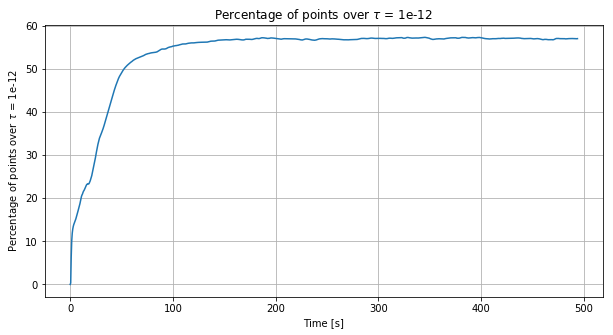

In [15]:
# plot of the non zero elements in function of the time 
plt.figure(figsize=(10,5))
plt.plot(time_df,100*np.sum(Z[:,:]>=thresh,axis=0)/Z.shape[0]);
plt.xlabel('Time [s]')
plt.ylabel(r'Percentage of points over $\tau$ = ' + str(thresh))
plt.grid()
plt.title(r'Percentage of points over $\tau$ = ' + str(thresh))


Text(0.5, 1.0, 'Percentage of points over $\\tau$ = 1e-12')

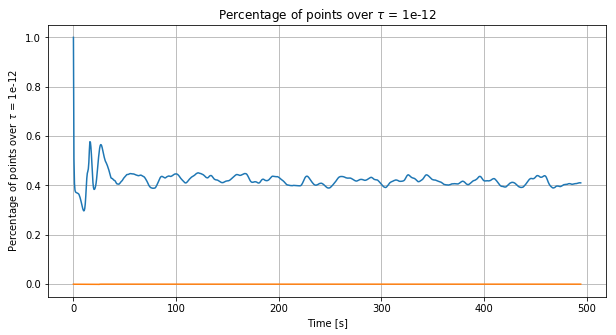

In [16]:
# plot of the non zero elements in function of the time 
plt.figure(figsize=(10,5))
plt.plot(time_df,np.max(Z[:,:],axis=0));
plt.plot(time_df,np.min(Z[:,:],axis=0));

plt.xlabel('Time [s]')
plt.ylabel(r'Percentage of points over $\tau$ = ' + str(thresh))
plt.grid()
plt.title(r'Percentage of points over $\tau$ = ' + str(thresh))


In [17]:
Z[S,:] = (Z[S,:] - Z[S,:].mean(axis=1,keepdims=True))

In [18]:
Z.shape

(100040, 989)

Plot of covariance in function of distance 

In [20]:
from sklearn.covariance import *


In [21]:
cov, shrinkage_coef = oas(Z[S,:].T)


In [79]:
i_0 = 3078#np.unravel_index(Z.argmax(), Z.shape)[0]
dist = (loc_df.loc[S,:]-loc_df.loc[i_0,:]).apply(np.linalg.norm,axis=1).values

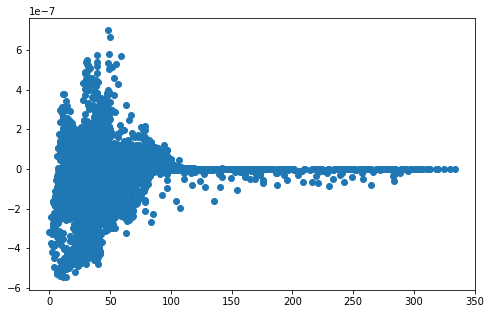

In [80]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
ax.set_yscale('linear')

ax.plot(dist,cov[i_0,:],'o')

In [81]:
np.unravel_index(Z.argmax(), Z.shape)[0]

9739

In [70]:
a = np.array([1]*10)
b = a.copy()
b[:2] = 0
b

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [71]:
a @ b

8